In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapefile as shp
import geopandas as gpd
import datetime
from statistics import mean, median
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import movingpandas as mpd
import warnings
warnings.filterwarnings('ignore')

## Data Import

In [2]:
car_df = pd.read_csv('car-assignments.csv')
gps_df = pd.read_csv('gps.csv')
loyalty_df = pd.read_csv('loyalty_data.csv', encoding='cp1252')
cc_df = pd.read_csv('cc_data.csv', encoding='cp1252')

In [3]:
car_df.head()

LastName FirstName  CarID   CurrentEmploymentType CurrentEmploymentTitle
0   Alcazar     Lucas    1.0  Information Technology            IT Helpdesk
1     Azada      Lars    2.0             Engineering               Engineer
2     Balas     Felix    3.0             Engineering               Engineer
3  Barranco    Ingrid    4.0               Executive                SVP/CFO
4      Baza      Isak    5.0  Information Technology          IT Technician

In [4]:
gps_df.head()

Timestamp  id        lat       long
0  01/06/2014 06:28:01  35  36.076225  24.874689
1  01/06/2014 06:28:01  35  36.076220  24.874596
2  01/06/2014 06:28:03  35  36.076211  24.874443
3  01/06/2014 06:28:05  35  36.076217  24.874253
4  01/06/2014 06:28:06  35  36.076214  24.874167

In [5]:
loyalty_df.head()

timestamp             location  price FirstName  LastName
0  1/6/2014  Brew've Been Served   4.17  Cornelia      Lais
1  1/6/2014  Brew've Been Served   9.60       Mat    Bramar
2  1/6/2014     Hallowed Grounds  16.53     Emile      Arpa
3  1/6/2014         Coffee Shack  11.51     Varro    Awelon
4  1/6/2014     Hallowed Grounds  12.93    Rachel  Pantanal

In [6]:
cc_df.head()

timestamp             location  price FirstName  LastName
0  1/6/2014 7:28  Brew've Been Served  11.34    Edvard      Vann
1  1/6/2014 7:34     Hallowed Grounds  52.22    Hideki  Cocinaro
2  1/6/2014 7:35  Brew've Been Served   8.33    Stenig     Fusil
3  1/6/2014 7:36     Hallowed Grounds  16.72  Birgitta    Frente
4  1/6/2014 7:37  Brew've Been Served   4.24      Sven    Flecha

## Data Exploration

In [7]:
car_df.dtypes

LastName                   object
FirstName                  object
CarID                     float64
CurrentEmploymentType      object
CurrentEmploymentTitle     object
dtype: object

In [8]:
for col in car_df:
    print(col,"\n", pd.unique(car_df[col]), "\n\n")

LastName 
 ['Alcazar' 'Azada' 'Balas' 'Barranco' 'Baza' 'Bergen' 'Borrasca' 'Calixto'
 'Calzas' 'Campo-Corrente' 'Cazar' 'Cocinaro' 'Ferro' 'Dedos' 'Bodrogi'
 'Vann' 'Flecha' 'Frente' 'Fusil' 'Osvaldo' 'Herrero' 'Lagos' 'Mies'
 'Nubarron' 'Onda' 'Orilla' 'Ovan' 'Resumir' 'Sanjorge Jr.' 'Strum'
 'Tempestad' 'Vasco-Pais' 'Hafon' 'Hawelon' 'Morlun' 'Morluniau' 'Nant'
 'Scozzese'] 


FirstName 
 ['Lucas' 'Lars' 'Felix' 'Ingrid' 'Isak' 'Linnea' 'Isande' 'Nils' 'Axel'
 'Ada' 'Gustav' 'Hideki' 'Inga' 'Lidelse' 'Loreto' 'Isia' 'Sven'
 'Birgitta' 'Vira' 'Stenig' 'Hennie' 'Kanon' 'Varja' 'Minke' 'Adra'
 'Marin' 'Kare' 'Elsa' 'Bertrand' 'Sten' 'Orhan' 'Brand' 'Edvard' 'Willem'
 'Albina' 'Benito' 'Claudio' 'Henk' 'Valeria' 'Adan' 'Cecilia' 'Irene'
 'Dylan'] 


CarID 
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. nan] 


CurrentEmploymentType 
 ['Information Technology' 'Engineering' 'Executive' 'Securi

In [9]:
car_df['CurrentEmploymentType'] = car_df['CurrentEmploymentType'].astype('category')
car_df['CurrentEmploymentTitle'] = car_df['CurrentEmploymentTitle'].astype('category')

In [10]:
car_df.dtypes

LastName                    object
FirstName                   object
CarID                      float64
CurrentEmploymentType     category
CurrentEmploymentTitle    category
dtype: object

In [11]:
loyalty_df.dtypes

timestamp     object
location      object
price        float64
FirstName     object
LastName      object
dtype: object

In [12]:
loyalty_df['location'] = loyalty_df['location'].astype('category')

In [13]:
for col in loyalty_df:
    print(col,"\n", pd.unique(loyalty_df[col]), "\n\n")

timestamp 
 ['1/6/2014' '1/7/2014' '1/8/2014' '1/9/2014' '1/10/2014' '1/11/2014'
 '1/12/2014' '1/13/2014' '1/14/2014' '1/15/2014' '1/16/2014' '1/17/2014'
 '1/18/2014' '1/19/2014'] 


location 
 ['Brew've Been Served', 'Hallowed Grounds', 'Coffee Shack', 'Abila Zacharo', 'Hippokampos', ..., 'Frank's Fuel', 'Chostus Hotel', 'Ahaggo Museum', 'Desafio Golf Course', 'Roberts and Sons']
Length: 33
Categories (33, object): ['Abila Airport', 'Abila Scrapyard', 'Abila Zacharo', 'Ahaggo Museum', ..., 'Roberts and Sons', 'Shoppers' Delight', 'Stewart and Sons Fabrication', 'U-Pump'] 


price 
 [  4.17   9.6   16.53 ...  35.01 110.02  63.17] 


FirstName 
 ['Cornelia' 'Mat' 'Emile' 'Varro' 'Rachel' 'Ruscella' 'Linda' 'Dante'
 'Carla' 'Anda' 'Lucas' 'Lars' 'Felix' 'Ingrid' 'Isak' 'Linnea' 'Loreto'
 'Isande' 'Nils' 'Axel' 'Ada' 'Gustav' 'Hideki' 'Lidelse' 'Inga' 'Sven'
 'Birgitta' 'Vira' 'Stenig' 'Albina' 'Kanon' 'Varja' 'Henk' 'Minke'
 'Cecilia' 'Adra' 'Marin' 'Elsa' 'Kare' 'Hennie' 'Bertrand' 'Orh

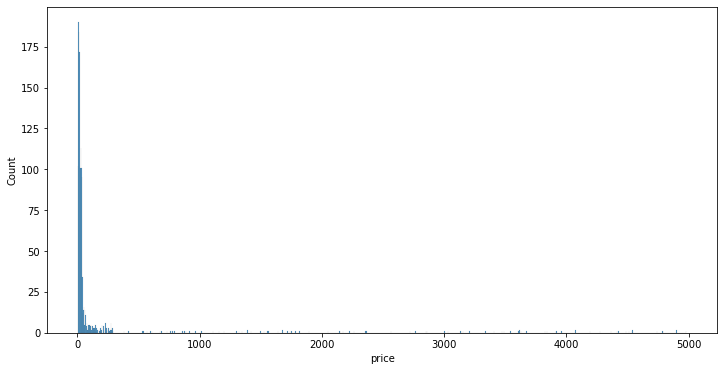

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(loyalty_df['price'], ax=ax)
plt.show()

In [15]:
outlier_purchase = loyalty_df.loc[loyalty_df['price'] > 1000]
outlier_purchase.head()

timestamp                      location    price FirstName   LastName
331  1/6/2014         Carlyle Chemical Inc.  3959.66    Albina      Hafon
332  1/6/2014                 Abila Airport  4540.08    Albina      Hafon
335  1/6/2014        Maximum Iron and Steel  2859.51    Albina      Hafon
347  1/6/2014  Stewart and Sons Fabrication  2144.62   Cecilia  Morluniau
423  1/7/2014                 Abila Airport  3840.37    Benito    Hawelon

In [16]:
for col in outlier_purchase:
    print(col,"\n", pd.unique(outlier_purchase[col]), "\n\n")

timestamp 
 ['1/6/2014' '1/7/2014' '1/8/2014' '1/9/2014' '1/10/2014' '1/13/2014'
 '1/14/2014' '1/15/2014' '1/16/2014' '1/17/2014'] 


location 
 ['Carlyle Chemical Inc.', 'Abila Airport', 'Maximum Iron and Steel', 'Stewart and Sons Fabrication', 'Nationwide Refinery', 'Kronos Pipe and Irrigation', 'Abila Scrapyard']
Categories (33, object): ['Abila Airport', 'Abila Scrapyard', 'Abila Zacharo', 'Ahaggo Museum', ..., 'Roberts and Sons', 'Shoppers' Delight', 'Stewart and Sons Fabrication', 'U-Pump'] 


price 
 [3959.66 4540.08 2859.51 2144.62 3840.37 1200.9  3411.29 3827.2  1562.66
 1347.36 1783.33 3920.82 3207.31 2149.28 1641.96 2723.18 2769.12 4513.16
 1738.26 4901.88 4367.43 3674.32 1673.77 4983.52 3615.61 3136.01 2358.22
 1420.39 1015.65 4538.52 2176.2  3544.   1527.14 1158.36 4792.5  1322.5
 2262.73 4195.49 1552.82 4074.1  3489.36 1718.96 3617.47 2852.74 4417.03
 2228.08 4071.95 2369.56 1301.01 4898.39 3630.57 3470.99 4277.4  3339.21
 4429.76 3152.41 4485.38 3608.08 1112.04 1392.73 3

In [17]:
employee_outlier_purchase = car_df.loc[car_df['FirstName'].isin(['Albina','Cecilia','Benito','Henk','Valeria','Irene','Dylan','Adan'
,'Claudio'])]
employee_outlier_purchase

LastName FirstName  CarID CurrentEmploymentType CurrentEmploymentTitle
35      Hafon    Albina    NaN            Facilities           Truck Driver
36    Hawelon    Benito    NaN            Facilities           Truck Driver
37    Hawelon   Claudio    NaN            Facilities           Truck Driver
38       Mies      Henk    NaN            Facilities           Truck Driver
39     Morlun   Valeria    NaN            Facilities           Truck Driver
40     Morlun      Adan    NaN            Facilities           Truck Driver
41  Morluniau   Cecilia    NaN            Facilities           Truck Driver
42       Nant     Irene    NaN            Facilities           Truck Driver
43   Scozzese     Dylan    NaN            Facilities           Truck Driver

In [18]:
outlier_purchase_suspicious = outlier_purchase.loc[outlier_purchase['LastName'] == 'Mies']
outlier_purchase_suspicious

timestamp       location    price FirstName LastName
430    1/7/2014  Abila Airport  3411.29      Henk     Mies
526    1/8/2014  Abila Airport  2723.18      Henk     Mies
527    1/8/2014  Abila Airport  2769.12      Henk     Mies
621    1/9/2014  Abila Airport  4538.52      Henk     Mies
887   1/13/2014  Abila Airport  4417.03      Henk     Mies
888   1/13/2014  Abila Airport  2228.08      Henk     Mies
978   1/14/2014  Abila Airport  4898.39      Henk     Mies
1071  1/15/2014  Abila Airport  3152.41      Henk     Mies
1174  1/16/2014  Abila Airport  3917.30      Henk     Mies
1175  1/16/2014  Abila Airport  3032.97      Henk     Mies

### Note - potential suspicious discrepancies. Very large outliers in price, worth investigating location these purchases were made to see if it makes sense. Only Truck drivers ever made single purchases over 1000 dollars. None of these people have assigned company cars.  

## Shapefile Experiments

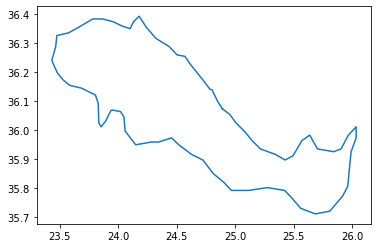

In [19]:
sf = shp.Reader("Geospatial/Kronos_Island.shp")

plt.figure()
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

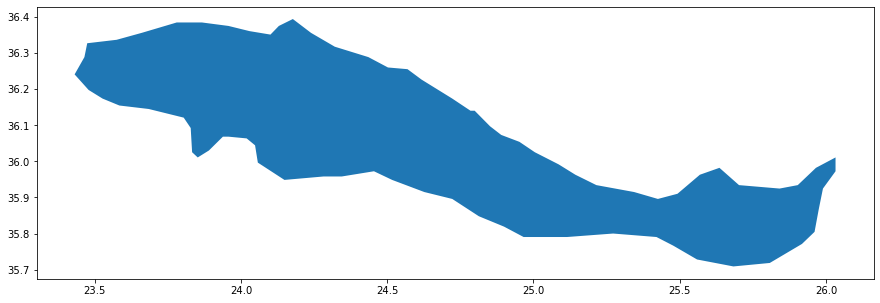

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
file_path = 'Geospatial/Kronos_Island.shp'
map_df = gpd.read_file(file_path)
map_df.plot(ax=ax)
plt.show()

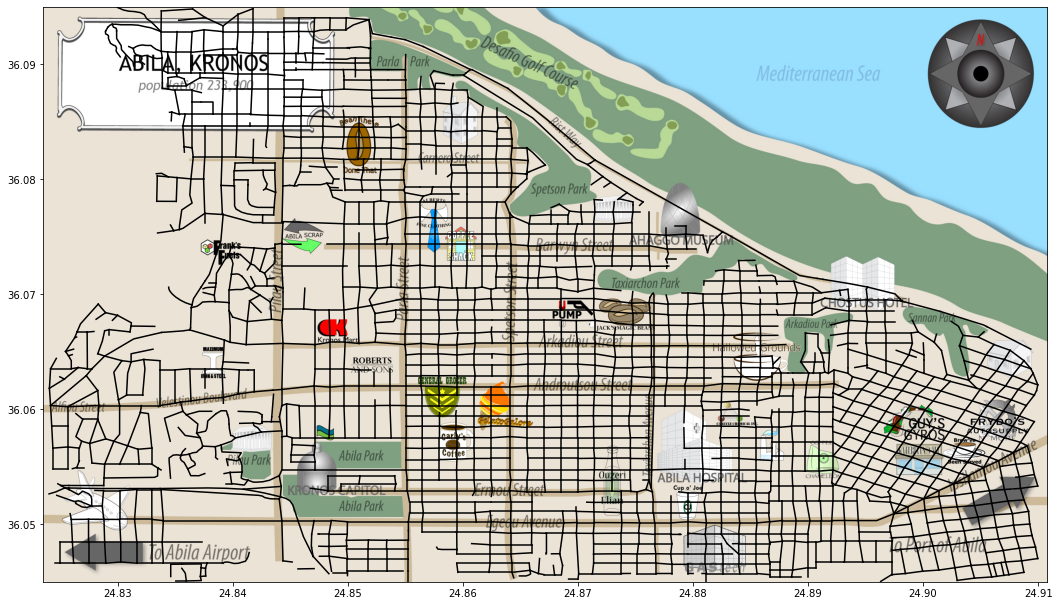

In [21]:
sf = shp.Reader("Geospatial/Abila.shp")

img = plt.imread("map-tourist.jpg")
fig, ax = plt.subplots(figsize=(18,18))
ax.imshow(img, extent=[24.8235, 24.9108, 36.045, 36.095])
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax = plt.plot(x,y, color ='k')
plt.show()

## Plotting Total Company Car Heat map over Abila

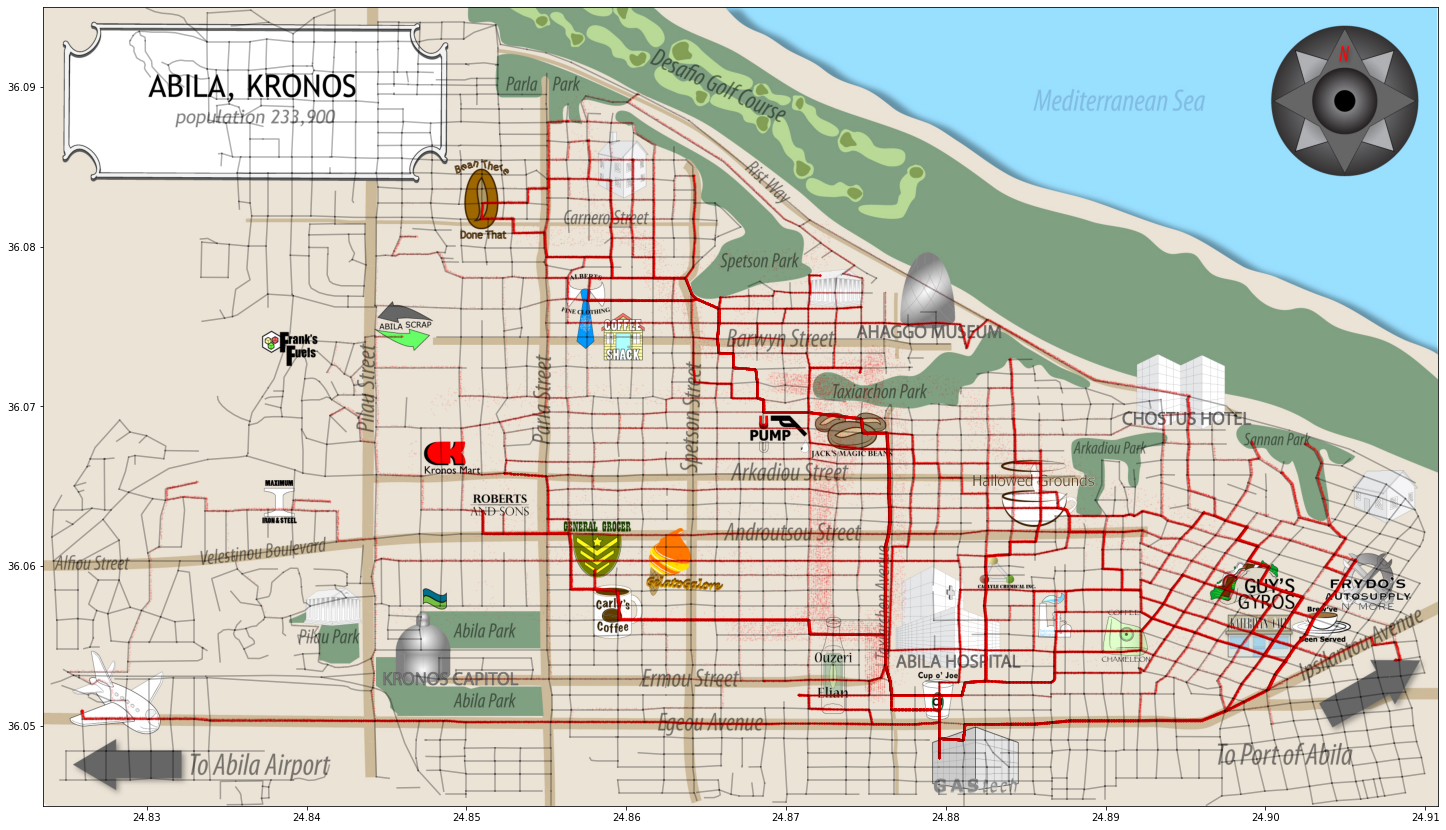

In [22]:
sf = shp.Reader("Geospatial/Abila.shp")

img = plt.imread("map-tourist.jpg")
fig, ax = plt.subplots(figsize=(25,20))
ax.imshow(img, extent=[24.8235, 24.9108, 36.045, 36.095])
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color ='k', alpha=0.3)

plt.scatter(gps_df['long'].values, gps_df['lat'].values, color='red', s=0.5, label='train', alpha=0.05)

plt.show()

## Identifying Employees Home Addresses and Plotting Them

In [23]:
##merge car_df and gps_df while dropping employees that do not have cars assigned to them, as well as cars that do not have employees assigned to them.
housing_df = car_df.rename(columns={'CarID':'id'}).dropna(how='any')
housing_df['id'] = housing_df['id'].astype(int)
housing_df = pd.merge(housing_df, gps_df, on='id')
housing_df['Dates'] = pd.to_datetime(housing_df['Timestamp']).dt.date
housing_df['Time'] = pd.to_datetime(housing_df['Timestamp']).dt.time

housing_df.head()

LastName FirstName  id   CurrentEmploymentType CurrentEmploymentTitle  \
0  Alcazar     Lucas   1  Information Technology            IT Helpdesk   
1  Alcazar     Lucas   1  Information Technology            IT Helpdesk   
2  Alcazar     Lucas   1  Information Technology            IT Helpdesk   
3  Alcazar     Lucas   1  Information Technology            IT Helpdesk   
4  Alcazar     Lucas   1  Information Technology            IT Helpdesk   

             Timestamp        lat       long       Dates      Time  
0  01/06/2014 07:20:01  36.066457  24.882582  2014-01-06  07:20:01  
1  01/06/2014 07:20:03  36.066344  24.882589  2014-01-06  07:20:03  
2  01/06/2014 07:20:06  36.066147  24.882584  2014-01-06  07:20:06  
3  01/06/2014 07:20:07  36.066130  24.882576  2014-01-06  07:20:07  
4  01/06/2014 07:20:10  36.065955  24.882615  2014-01-06  07:20:10

In [24]:
##Finds the earlist time an employee uses their car each day and records the GPS coordinates. Then takes the median of 
##those total coordinates to find the most common location an employee starts their day. This is likely their home address.
employee_addresses = []
for i in pd.unique(housing_df['id']):
    latitudes = []
    longitudes = []
    temp_housing_df = housing_df.loc[housing_df['id']==i]
    for j in pd.unique(temp_housing_df['Dates']):
        j_date = temp_housing_df.loc[temp_housing_df['Dates']==j]
        earliest_time = j_date.iloc[[0]]
        latitudes.append(earliest_time['lat'].item())
        longitudes.append(earliest_time['long'].item())
        
    employee_addresses.append([i,(round(median(latitudes),3), round(median(longitudes),3))])
    
print(employee_addresses)

[[1, (36.066, 24.883)], [2, (36.085, 24.86)], [3, (36.087, 24.858)], [4, (36.078, 24.872)], [5, (36.067, 24.878)], [6, (36.059, 24.895)], [7, (36.084, 24.864)], [8, (36.067, 24.886)], [9, (36.082, 24.856)], [10, (36.077, 24.866)], [11, (36.084, 24.859)], [12, (36.068, 24.899)], [13, (36.06, 24.906)], [14, (36.063, 24.896)], [15, (36.06, 24.906)], [16, (36.06, 24.906)], [17, (36.063, 24.899)], [18, (36.063, 24.896)], [19, (36.088, 24.856)], [20, (36.066, 24.901)], [21, (36.06, 24.906)], [22, (36.058, 24.901)], [23, (36.058, 24.901)], [24, (36.062, 24.899)], [25, (36.059, 24.895)], [26, (36.073, 24.884)], [27, (36.069, 24.884)], [28, (36.073, 24.876)], [29, (36.059, 24.895)], [30, (36.058, 24.901)], [31, (36.071, 24.895)], [32, (36.072, 24.875)], [33, (36.062, 24.899)], [34, (36.068, 24.902)], [35, (36.076, 24.875)]]


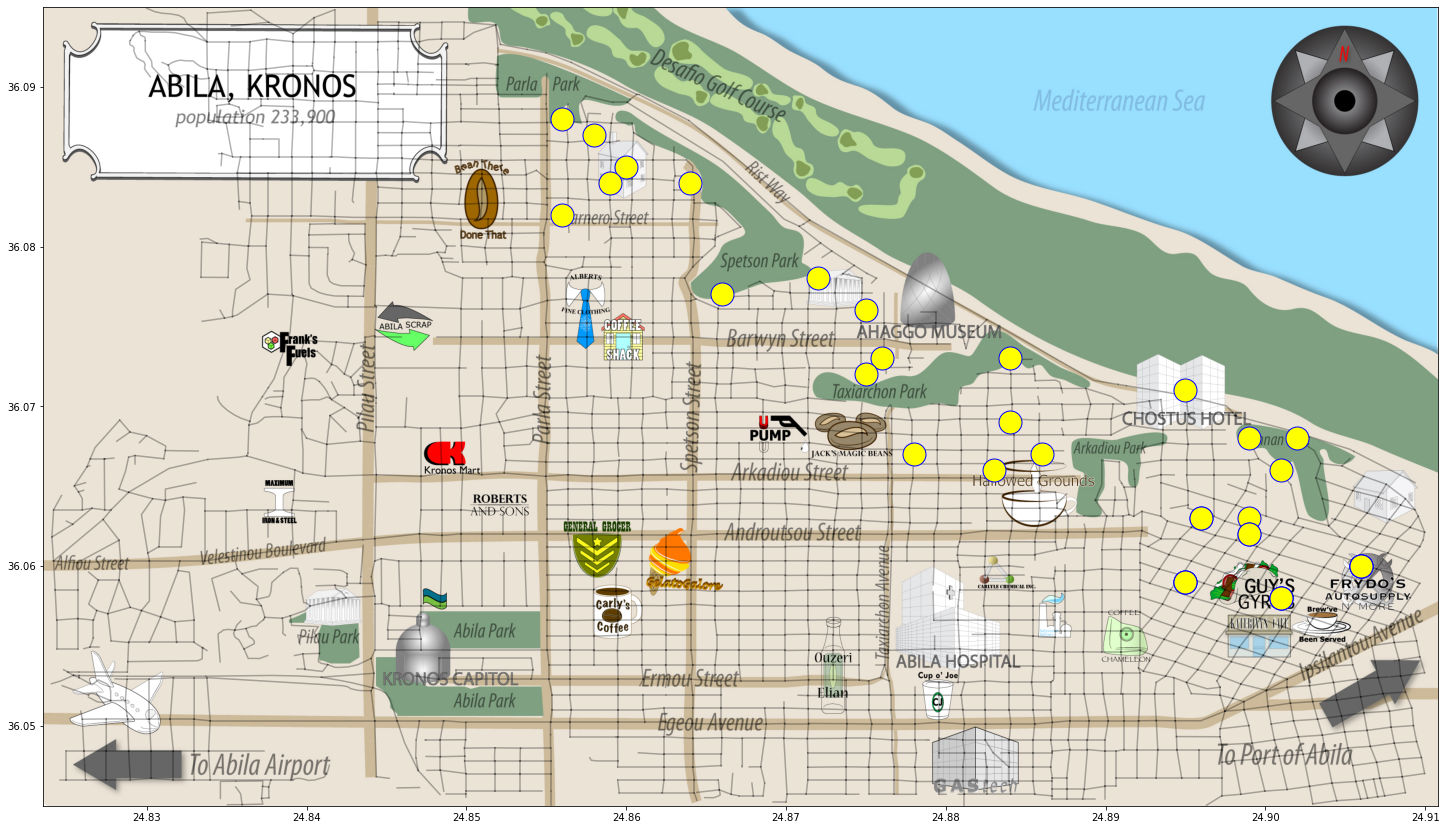

35


In [25]:
##need to find a way to annotate better when multiple people are living in the same location
sf = shp.Reader("Geospatial/Abila.shp")

img = plt.imread("map-tourist.jpg")
fig, ax = plt.subplots(figsize=(25,20))
ax.imshow(img, extent=[24.8235, 24.9108, 36.045, 36.095])
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color ='k', alpha=0.3)

xy_list = []
for i in employee_addresses:
    car_id = i[0]
    y=i[1][0]
    x=i[1][1]

    plt.plot(x,y,marker='o',markersize=23, markeredgecolor='blue', markerfacecolor='yellow')
    xy_list.append([x,y])

plt.show()
print(len(xy_list))

## Trajectory Construction

In [139]:
##Breaking data into trajectories, anytime a person doesn't travel for more than 1 hour, a new trajectory is formed.
##In the end you have a list of 35 trajectory collections, one collection for each registered vehicle. 
##You could apply this same process to the vehicles that are not assigned to an individual, but for now I restricted it to assigned company cars
##Additionally if you want fewer trajectories/trips, you can change the 'hours' keyword in the ObservationGapSplitter split function.

housing_df['Timestamp'] = pd.to_datetime(housing_df['Timestamp'], format='%m/%d/%Y %H:%M:%S')

trajectories_df = housing_df.set_index('Timestamp')

min_length = 100
trajectories_collection = mpd.TrajectoryCollection(trajectories_df, traj_id_col='id', x='long', y='lat',min_length=min_length)

trajectories_total = []
start_end_totals = []

for trajectory in trajectories_collection:
    traj = mpd.ObservationGapSplitter(trajectory).split(gap=datetime.timedelta(hours=1))
    start_end = mpd.DouglasPeuckerGeneralizer(traj).generalize(tolerance=1.0)
    trajectories_total.append(traj)
    start_end_totals.append(start_end)

In [140]:
##Check out documentation for movingPandas trajectory collection for info on how to access the data. 

print(trajectories_total)
print(len(trajectories_total))
print(start_end_totals)
print(len(start_end_totals))

[TrajectoryCollection with 68 trajectories, TrajectoryCollection with 61 trajectories, TrajectoryCollection with 60 trajectories, TrajectoryCollection with 62 trajectories, TrajectoryCollection with 58 trajectories, TrajectoryCollection with 60 trajectories, TrajectoryCollection with 62 trajectories, TrajectoryCollection with 58 trajectories, TrajectoryCollection with 59 trajectories, TrajectoryCollection with 70 trajectories, TrajectoryCollection with 61 trajectories, TrajectoryCollection with 60 trajectories, TrajectoryCollection with 63 trajectories, TrajectoryCollection with 65 trajectories, TrajectoryCollection with 68 trajectories, TrajectoryCollection with 70 trajectories, TrajectoryCollection with 62 trajectories, TrajectoryCollection with 62 trajectories, TrajectoryCollection with 64 trajectories, TrajectoryCollection with 58 trajectories, TrajectoryCollection with 68 trajectories, TrajectoryCollection with 55 trajectories, TrajectoryCollection with 63 trajectories, Trajectory

In [141]:
Alcazar_Lucas = []
for i in trajectories_total:
    for trajectory in i:
        trajectory.add_speed(overwrite=True)
        trajectory.add_direction(overwrite=True)
        Alcazar_Lucas.append(trajectory)
    break

Alcazar_Lucas[0].df

LastName FirstName  id   CurrentEmploymentType  \
Timestamp                                                            
2014-01-06 07:20:01  Alcazar     Lucas   1  Information Technology   
2014-01-06 07:20:03  Alcazar     Lucas   1  Information Technology   
2014-01-06 07:20:06  Alcazar     Lucas   1  Information Technology   
2014-01-06 07:20:07  Alcazar     Lucas   1  Information Technology   
2014-01-06 07:20:10  Alcazar     Lucas   1  Information Technology   
...                      ...       ...  ..                     ...   
2014-01-06 08:04:05  Alcazar     Lucas   1  Information Technology   
2014-01-06 08:04:06  Alcazar     Lucas   1  Information Technology   
2014-01-06 08:04:07  Alcazar     Lucas   1  Information Technology   
2014-01-06 08:04:08  Alcazar     Lucas   1  Information Technology   
2014-01-06 08:04:09  Alcazar     Lucas   1  Information Technology   

                    CurrentEmploymentTitle       Dates      Time  \
Timestamp                                                          
2014-01-06 07:20:01            IT Helpdesk  2014-01-06  07:20:01   
2014-01-06 07:20:03            IT Helpdesk  2014-01-06  07:20:03   
2014-01-06 07:20:06            IT Helpdesk  2014-01-06  07:20:06   
2014-01-06 07:20:07            IT Helpdesk  2014-01-06  07:20:07   
2014-01-06 07:20:10            IT Helpdesk  2014-01-06  07:20:10   
...                                    ...         ...       ...   
2014-01-06 08:04:05            IT Helpdesk  2014-01-06  08:04:05   
2014-01-06 08:04:06            IT Helpdesk  2014-01-06  08:04:06   
2014-01-06 08:04:07            IT Helpdesk  2014-01-06  08:04:07   
2014-01-06 08:04:08            IT Helpdesk  2014-01-06  08:04:08   
2014-01-06 08:04:09            IT Helpdesk  2014-01-06  08:04:09   

                                      geometry     speed   direction  
Timestamp                                                             
2014-01-06 07:20:01  POINT (24.88258 36.06646)  6.254100  177.188604  
2014-01-06 07:20:03  POINT (24.88259 36.06634)  6.254100  177.188604  
2014-01-06 07:20:06  POINT (24.88258 36.06615)  7.303248  181.229167  
2014-01-06 07:20:07  POINT (24.88258 36.06613)  2.028266  200.432088  
2014-01-06 07:20:10  POINT (24.88262 36.06595)  6.580820  169.750449  
...                                        ...       ...         ...  
2014-01-06 08:04:05  POINT (24.87957 36.04813)  5.160570  178.914233  
2014-01-06 08:04:06  POINT (24.87957 36.04808)  5.227690  181.357039  
2014-01-06 08:04:07  POINT (24.87957 36.04803)  6.192360  176.810763  
2014-01-06 08:04:08  POINT (24.87957 36.04802)  0.487253  189.539617  
2014-01-06 08:04:09  POINT (24.87957 36.04803)  0.672106   14.221517  

[405 rows x 10 columns]

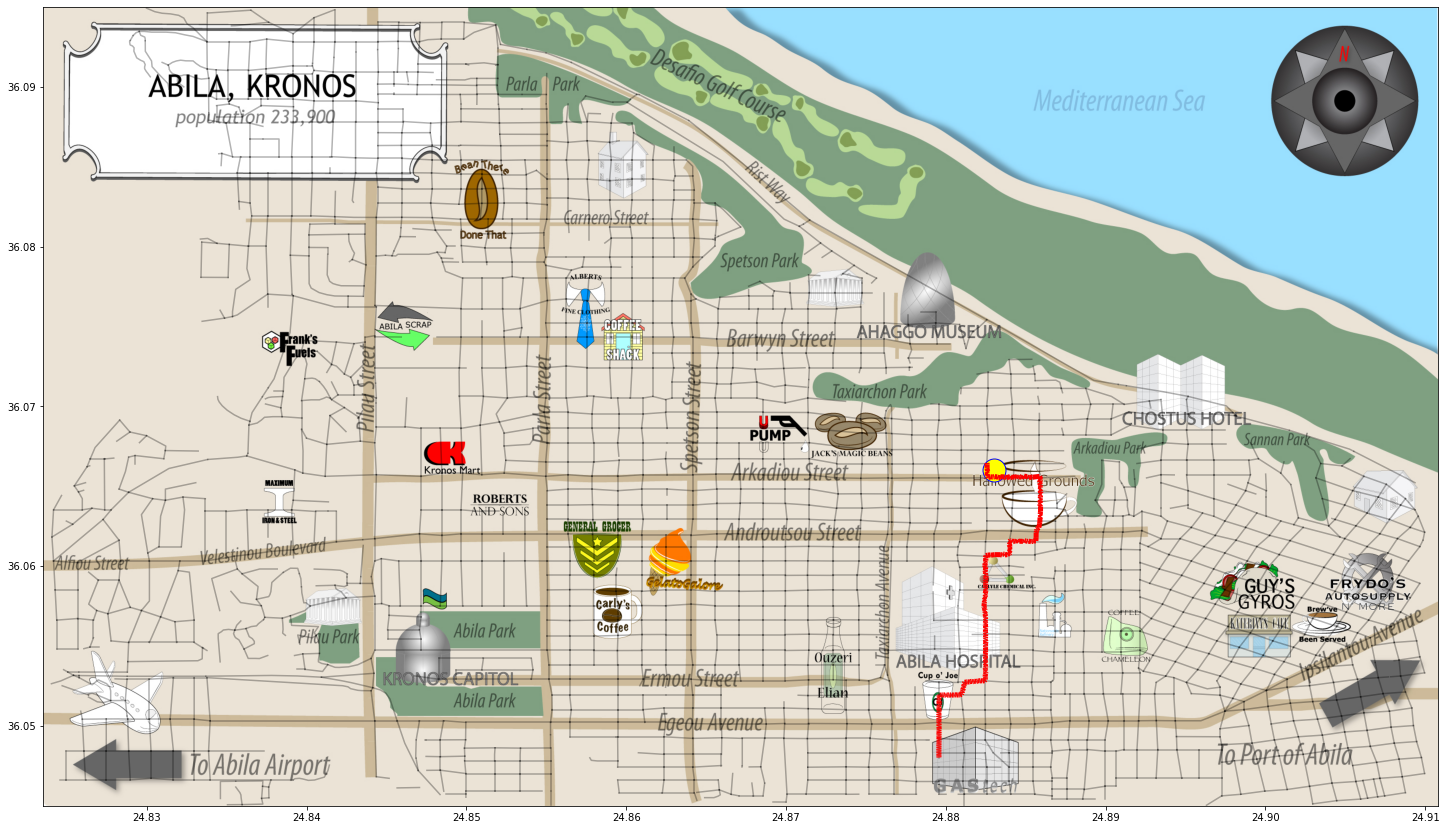

In [159]:
##An example of plotting a single trajectory (shown above), Lucas Alcazar's morning commute on 01/06/2014.
##Could be very useful for clustering/outlier detection/identifying daily routines.
sf = shp.Reader("Geospatial/Abila.shp")

img = plt.imread("map-tourist.jpg")
fig, ax = plt.subplots(figsize=(25,20))
ax.imshow(img, extent=[24.8235, 24.9108, 36.045, 36.095])
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color ='k', alpha=0.3)

plt.plot(employee_addresses[0][1][1],employee_addresses[0][1][0],marker='o',markersize=23, markeredgecolor='blue', markerfacecolor='yellow')
Alcazar_Lucas[0].plot(linewidth=5, color='red', alpha=1, ax=ax)

plt.show()

## Clustering on start and end points of Trajectories

In [158]:
terminal_points_df = pd.DataFrame()
x_points = []
y_points = []
ids = []
timestamps = []

id_count = 1
for i in start_end_totals:
    for j in i:
        timestamps.append(j.df.index[0])
        timestamps.append(j.df.index[1])
        for k in j.df['geometry']:
            x_points.append(k.x)
            y_points.append(k.y)
            ids.append(id_count)
    id_count += 1

terminal_points_df['id'] = ids
terminal_points_df['x'] = x_points
terminal_points_df['y'] = y_points
terminal_points_df['Timestamp'] = timestamps
terminal_points_df

id          x          y           Timestamp
0      1  24.882582  36.066457 2014-01-06 07:20:01
1      1  24.879575  36.048029 2014-01-06 08:04:09
2      1  24.879572  36.048025 2014-01-06 12:17:01
3      1  24.879572  36.048029 2014-01-06 13:34:27
4      1  24.879570  36.048032 2014-01-06 17:44:01
...   ..        ...        ...                 ...
4265  35  24.874667  36.076262 2014-01-19 16:06:17
4266  35  24.874702  36.076255 2014-01-19 18:43:01
4267  35  24.857574  36.076665 2014-01-19 18:46:19
4268  35  24.857619  36.076631 2014-01-19 20:04:01
4269  35  24.874629  36.076234 2014-01-19 20:07:17

[4270 rows x 4 columns]

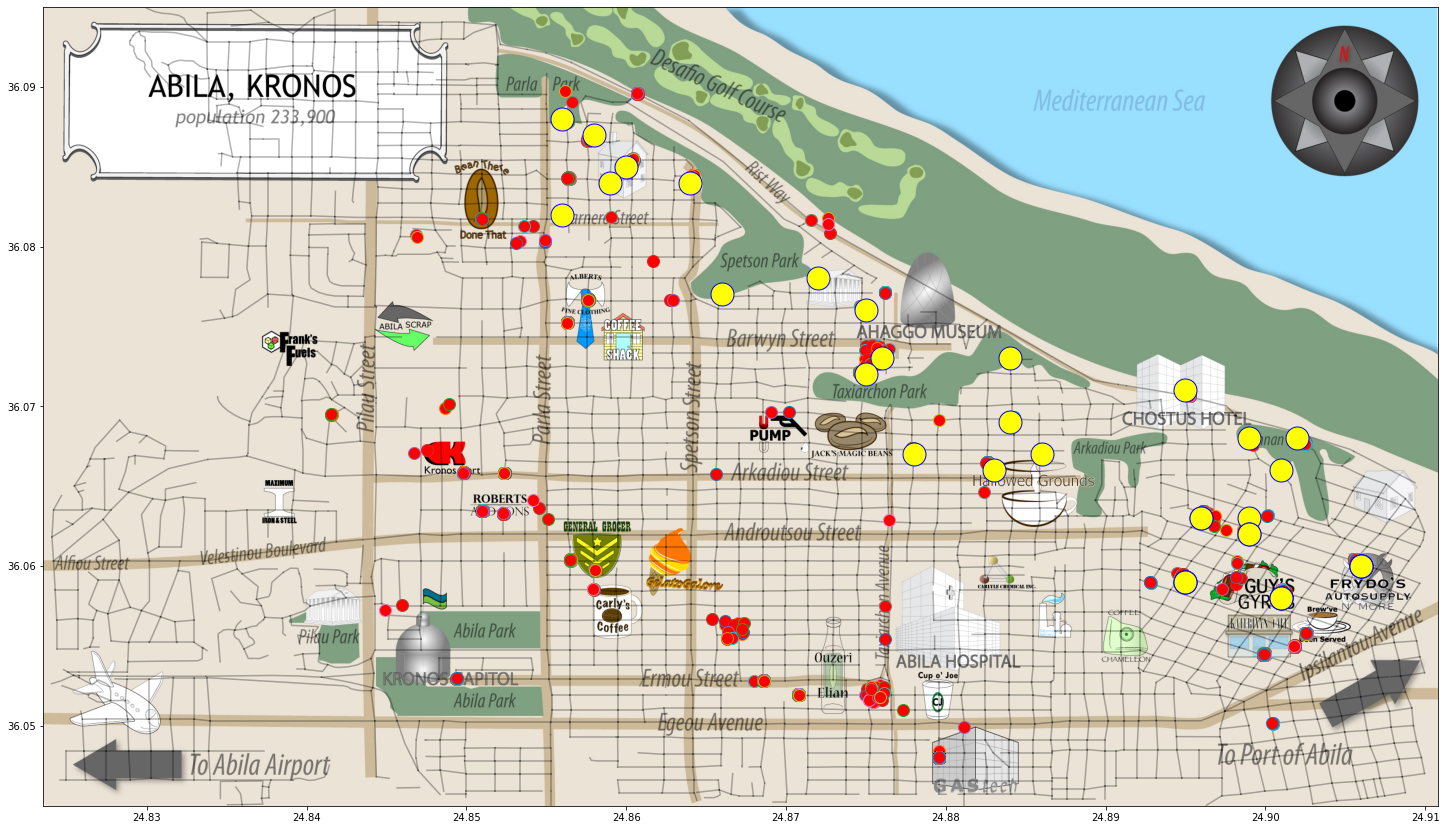

In [165]:
##Example start and end point plot on employee with car id 1
sf = shp.Reader("Geospatial/Abila.shp")

img = plt.imread("map-tourist.jpg")
fig, ax = plt.subplots(figsize=(25,20))
ax.imshow(img, extent=[24.8235, 24.9108, 36.045, 36.095])
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color ='k', alpha=0.3)

for row in terminal_points_df.iterrows():
    plt.plot(row[1][1],row[1][2],marker='o',markersize=12, markerfacecolor='red')
for i in employee_addresses:
    car_id = i[0]
    y=i[1][0]
    x=i[1][1]

    plt.plot(x,y,marker='o',markersize=23, markeredgecolor='blue', markerfacecolor='yellow')
    
plt.show()

## Clustering on Trajectory Terminal Points, Seems like a failed experiment. 

In [161]:
points_df = terminal_points_df.drop('id', axis=1)
kmeans = KMeans(n_clusters=2, random_state=19) 
kmeans.fit(points_df)
kmeans.labels_

sns.scatterplot(x = points_df['x'], y = points_df['y'], hue=kmeans.labels_)

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[datetime64]'>)

In [121]:
points_df = terminal_points_df.drop('id', axis=1)

model = DBSCAN().fit(points_df)
print(model.labels_)


print("number of cluster found: {}".format(len(set(model.labels_))))
print('cluster for each point: ', model.labels_)

[0 0 0 ... 0 0 0]
number of cluster found: 1
cluster for each point:  [0 0 0 ... 0 0 0]


## Outlier Detection on Trajectory Terminal Points